# Discount f/g Count Calibration

**Setup:** Run with an environment that has `cmdstanpy`, `numpy`, `matplotlib`, and `ppi-python` (e.g. `conda activate stan`; `pip install ppi-python`).

This notebook:
1. Loads the discount f/g data (**f** = true count, **g** = detector count)
2. Randomly splits data into labeled and unlabeled subsets
3. Fits the Poisson count calibration model to estimate the **max count** across all (labeled + unlabeled) data
4. Compares **mean** estimation using Poisson calibration, PPI, and DISCount

---

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from cmdstanpy import CmdStanModel
from ppi_py import ppi_mean_pointestimate, ppi_mean_ci

/Users/LOF19/miniconda3/envs/stan/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load the data

In [2]:
with open("2025-11-19_discount_f_g.json") as f:
    data_raw = json.load(f)

f = np.array(data_raw["f"], dtype=np.int32)  # true counts
g = np.array(data_raw["g"], dtype=np.float64)  # detector counts

N = len(f)
print(f"Loaded {N} paired observations")
print(f"f (true count):  min={f.min()}, max={f.max()}, mean={f.mean():.2f}")
print(f"g (detector):    min={g.min()}, max={g.max()}, mean={g.mean():.2f}")

Loaded 658 paired observations
f (true count):  min=0, max=36, mean=9.14
g (detector):    min=0.0, max=34.0, mean=7.44


## 2. Random split into labeled and unlabeled

In [3]:
rng = np.random.default_rng(42)
frac_labeled = 0.05  # use 25% as labeled, 75% as unlabeled
n_labeled = int(N * frac_labeled)
n_labeled = max(n_labeled, 50)  # ensure at least 50 labeled

idx = rng.permutation(N)
idx_labeled = idx[:n_labeled]
idx_unlabeled = idx[n_labeled:]

f_labeled = f[idx_labeled]
g_labeled = g[idx_labeled]
f_unlabeled = f[idx_unlabeled]
g_unlabeled = g[idx_unlabeled]

n_unlabeled = N - n_labeled
print(f"Labeled:   {n_labeled} obs (f known)")
print(f"Unlabeled: {n_unlabeled} obs (f treated as unknown)")

Labeled:   50 obs (f known)
Unlabeled: 608 obs (f treated as unknown)


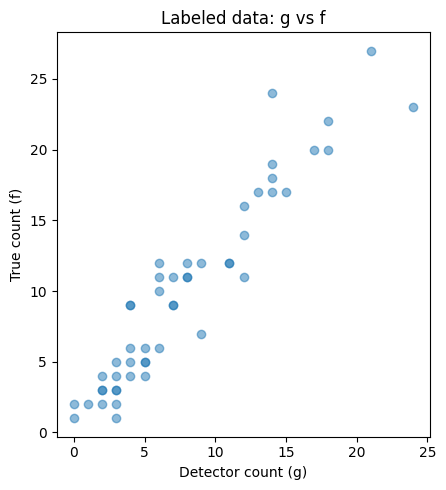

In [4]:
# Quick sanity plot: detector (g) vs true (f) for labeled data
fig, ax = plt.subplots(figsize=(6, 5))
ax.scatter(g_labeled, f_labeled, alpha=0.5)
ax.set_xlabel("Detector count (g)")
ax.set_ylabel("True count (f)")
ax.set_title("Labeled data: g vs f")
ax.set_aspect("equal")
plt.tight_layout()
plt.show()

## 3. Fit the Poisson count calibration model

In [5]:
epsilon = 1e-6

data = {
    "N_labeled": n_labeled,
    "N_unlabeled": n_unlabeled,
    "predicted_counts_labeled": g_labeled,
    "true_counts_labeled": f_labeled,
    "predicted_counts_unlabeled": g_unlabeled,
    "epsilon": epsilon,
}

model = CmdStanModel(stan_file="poisson_count_calibration.stan")
fit = model.sample(data=data, seed=123, show_progress=True)

23:40:42 - cmdstanpy - INFO - CmdStan start processing
chain 1:   0%|          | 0/2000 [00:00<?, ?it/s, (Warmup)]


chain 1:  50%|█████     | 1000/2000 [00:00<00:00, 18492.18it/s, (Sampling)]


chain 1:  60%|██████    | 1200/2000 [00:00<00:00, 10842.92it/s, (Sampling)]


chain 2: 100%|██████████| 2000/2000 [00:00<00:00, 5747.39it/s, (Sampling completed)] 

chain 3: 100%|██████████| 2000/2000 [00:00<00:00, 5750.33it/s, (Sampling completed)] 


chain 4: 100%|██████████| 2000/2000 [00:00<00:00, 5751.80it/s, (Sampling completed)] 


23:40:42 - cmdstanpy - INFO - CmdStan done processing.


## 4. Estimate max count across all data

For labeled data we observe the true count directly. For unlabeled data we use the posterior predictive samples. The max count across all data is the maximum of:
- max(true counts in labeled)
- max(posterior predictive true counts in unlabeled, per draw)

In [6]:
max_labeled = int(f_labeled.max())
rep = fit.stan_variable("true_counts_unlabeled_rep")  # shape (draws, N_unlabeled)

# For each MCMC draw: max over unlabeled for that draw
max_unlabeled_per_draw = np.max(rep, axis=1)
# Max over all data per draw = max(max_labeled, max_unlabeled)
max_all_per_draw = np.maximum(max_labeled, max_unlabeled_per_draw)

print("Max count across all data:")
print(f"  Posterior mean: {max_all_per_draw.mean():.1f}")
print(f"  Posterior median: {np.median(max_all_per_draw):.1f}")
print(f"  90% credible interval: [{np.percentile(max_all_per_draw, 5):.0f}, {np.percentile(max_all_per_draw, 95):.0f}]")
print(f"\n(For comparison: observed max in full data = {f.max()})")

Max count across all data:
  Posterior mean: 32.0
  Posterior median: 31.0
  90% credible interval: [27, 40]

(For comparison: observed max in full data = 36)


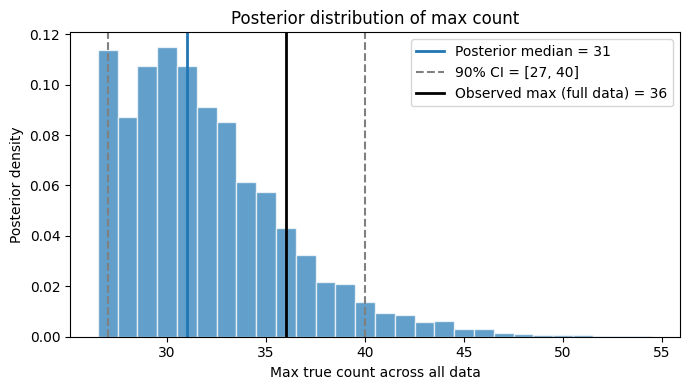

In [7]:
plt.figure(figsize=(7, 4))
plt.hist(max_all_per_draw, bins=np.arange(max_all_per_draw.min(), max_all_per_draw.max() + 2) - 0.5, 
         color="C0", alpha=0.7, edgecolor="white", density=True)
plt.axvline(np.median(max_all_per_draw), color="C0", lw=2, label=f"Posterior median = {np.median(max_all_per_draw):.0f}")
lo, hi = np.percentile(max_all_per_draw, [5, 95])
plt.axvline(lo, color="gray", ls="--", lw=1.5, label=f"90% CI = [{lo:.0f}, {hi:.0f}]")
plt.axvline(hi, color="gray", ls="--", lw=1.5)
plt.axvline(f.max(), color="black", lw=2, label=f"Observed max (full data) = {f.max()}")
plt.xlabel("Max true count across all data")
plt.ylabel("Posterior density")
plt.title("Posterior distribution of max count")
plt.legend()
plt.tight_layout()
plt.show()

## 5. Model diagnostics (optional)

Posterior of alpha and beta, and mean rays per image.

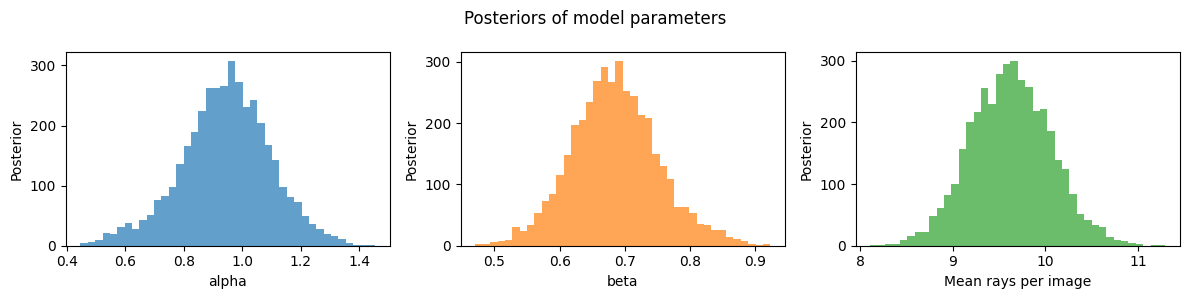

In [8]:
alpha = fit.stan_variable("alpha")
beta = fit.stan_variable("beta")
mean_rays = fit.stan_variable("mean_rays_per_image")

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
axes[0].hist(alpha, bins=40, color="C0", alpha=0.7)
axes[0].set_xlabel("alpha")
axes[0].set_ylabel("Posterior")
axes[1].hist(beta, bins=40, color="C1", alpha=0.7)
axes[1].set_xlabel("beta")
axes[1].set_ylabel("Posterior")
axes[2].hist(mean_rays, bins=40, color="C2", alpha=0.7)
axes[2].set_xlabel("Mean rays per image")
axes[2].set_ylabel("Posterior")
plt.suptitle("Posteriors of model parameters")
plt.tight_layout()
plt.show()

## 6. Mean estimation: PPI and DISCount

Compare three methods for estimating the **mean** true count E[f]:
- **Poisson calibration**: posterior mean of `mean_rays_per_image` (already computed above)
- **Prediction Powered Inference (PPI)**: debiases detector predictions using labeled data
- **DISCount**: detector-based importance sampling — samples proportionally to g, then importance-weights to get unbiased mean

In [9]:
# --- Poisson calibration mean (from Stan fit) ---
mean_poisson = float(fit.stan_variable("mean_rays_per_image").mean())
ci_poisson_lo, ci_poisson_hi = np.percentile(fit.stan_variable("mean_rays_per_image"), [5, 95])

# --- PPI mean (Prediction Powered Inference) ---
# Y=true count, Yhat=detector count. PPI debiases using: theta_ppi = mean(Yhat_unlabeled) + mean(Y - Yhat_labeled)
mean_ppi = ppi_mean_pointestimate(
    Y=f_labeled.astype(np.float64),
    Yhat=g_labeled,
    Yhat_unlabeled=g_unlabeled,
)
ci_ppi = ppi_mean_ci(
    Y=f_labeled.astype(np.float64),
    Yhat=g_labeled,
    Yhat_unlabeled=g_unlabeled,
    alpha=0.1,
)
# Extract scalars in case ppi_mean_ci returns arrays
ci_ppi_lo = float(np.atleast_1d(ci_ppi[0])[0])
ci_ppi_hi = float(np.atleast_1d(ci_ppi[1])[0])

# --- DISCount mean (Detector-based Importance Sampling) ---
# Sample n units with probability proportional to g+epsilon. Unbiased for total via IS.
# F_hat = (1/n) * sum_{sampled} f_i / q_i,  mean_hat = F_hat / N
# q_i = (g_i + eps) / sum(g + eps)
eps = 1e-6
q = (g + eps) / (g + eps).sum()
# Simulate DISCount sampling: draw n indices with prob proportional to g
idx_discount = rng.choice(N, size=n_labeled, replace=False, p=q)
f_discount = f[idx_discount]
g_discount = g[idx_discount]
q_discount = q[idx_discount]
# Importance sampling estimator for total count
F_hat_discount = (1 / n_labeled) * (f_discount / q_discount).sum()
mean_discount = F_hat_discount / N

# Bootstrap CI for DISCount (standard error of IS estimator)
n_boot = 1000
boot_means = []
for _ in range(n_boot):
    idx_b = rng.choice(n_labeled, size=n_labeled, replace=True)
    F_b = (1 / n_labeled) * (f_discount[idx_b] / q_discount[idx_b]).sum()
    boot_means.append(F_b / N)
ci_discount = (np.percentile(boot_means, 5), np.percentile(boot_means, 95))

# --- Summary ---
true_mean = f.mean()
print("Mean true count E[f] — comparison")
print("=" * 50)
print(f"Ground truth (full data):     {true_mean:.3f}")
print(f"Poisson calibration:         {mean_poisson:.3f}   [90% CI: {ci_poisson_lo:.3f}, {ci_poisson_hi:.3f}]")
print(f"PPI:                         {float(mean_ppi):.3f}   [90% CI: {ci_ppi_lo:.3f}, {ci_ppi_hi:.3f}]")
print(f"DISCount (importance samp):  {mean_discount:.3f}   [90% CI: {ci_discount[0]:.3f}, {ci_discount[1]:.3f}]")

Mean true count E[f] — comparison
Ground truth (full data):     9.135
Poisson calibration:         9.627   [90% CI: 8.923, 10.339]
PPI:                         9.488   [90% CI: 8.851, 10.124]
DISCount (importance samp):  8.838   [90% CI: 8.399, 9.289]


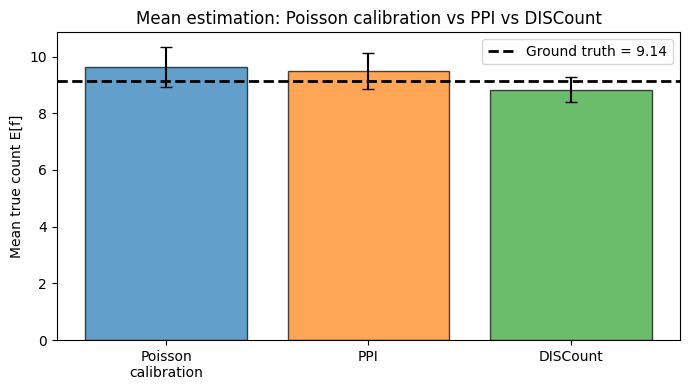

In [10]:
# Visual comparison
methods = ["Poisson\ncalibration", "PPI", "DISCount"]
means = [mean_poisson, float(mean_ppi), mean_discount]
lo = [ci_poisson_lo, ci_ppi_lo, ci_discount[0]]
hi = [ci_poisson_hi, ci_ppi_hi, ci_discount[1]]

fig, ax = plt.subplots(figsize=(7, 4))
x = np.arange(len(methods))
ax.bar(x, means, color=["C0", "C1", "C2"], alpha=0.7, edgecolor="black")
ax.errorbar(x, means, yerr=[np.array(means) - np.array(lo), np.array(hi) - np.array(means)],
            fmt="none", color="black", capsize=4)
ax.axhline(true_mean, color="black", ls="--", lw=2, label=f"Ground truth = {true_mean:.2f}")
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.set_ylabel("Mean true count E[f]")
ax.set_title("Mean estimation: Poisson calibration vs PPI vs DISCount")
ax.legend()
ax.set_ylim(0, None)
plt.tight_layout()
plt.show()